# Conditional AutoEncoder Model을 만들기


> AE모델을 Dense를 사용하는 것이 아닌 Conv를 사용하라 하셨기 때문에 이전에 만들었던 모델 중 loss의 값이 가상 우수했던 모델을 가져와서 Base로 삼고자 한다.


>  하지만 이때 잠재벡터 z의 값을 효과적으로 보이기 위해 n_dim의 값을 4가 아닌 2를 삽입해서 활용한다. 추후 z차원을 증대시킬 때 4값을 사용한다.



## condition 추가 방법


1.    Condition을 주기 위해 Label데이터를 인풋 데이터의 형태에 맞추어 마지막 차원에 1과 0인 차원을 추가하는 방식 예를들어 Label이 0일경우 [1,0,0,0,0,0,0,0,0,0]의 값을 모든 값 하나하나에 다 삽입하는 방식으로 condition을 추가하고자 한다.
2.    처음 input에는 [28,10]의 꼴로 변환하여 작업을 진행하였으며 Z값에 condition을 추가하기 위해 [1,10]꼴로 만들어 데이터를 추가로 concating하여 작업을 진행하고자 한다.






In [ ]:
# 사용하고자 하는 모듈 import
import tensorflow as tf                       
from tensorflow.keras import models, layers   
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [ ]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images의 *원래* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *원래* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

# Normalizing the images to the range of [0., 1.]
train_images = tf.cast(train_images, tf.float32)
test_images  = tf.cast(test_images, tf.float32)
train_images /= 255
test_images  /= 255

print('train_images의 *바뀐* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *바뀐* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

11493376/11490434 [==============================] - 0s 0us/step
train_images의 *원래* 데이터의 shape과 dype: (60000, 28, 28) uint8
test_images의 *원래* 데이터의 shape과 dype: (10000, 28, 28) uint8
train_images의 *바뀐* 데이터의 shape과 dype: (60000, 28, 28) <dtype: 'float32'>
test_images의 *바뀐* 데이터의 shape과 dype: (10000, 28, 28) <dtype: 'float32'>


In [ ]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

# 데이터 변환 확인
print(train_label_onehots.shape)
print(test_label_onehots.shape)

print(train_label_onehots[0])
print(train_labels[0])
print(test_label_onehots[0])
print(test_labels[0])

(60000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


## 기본 Base 모델의 구조 확인

In [ ]:
n_dim = 4
enc = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(28,28)),
                                  tf.keras.layers.Conv1D(128,kernel_size=5,activation='elu',strides=2),
                                  tf.keras.layers.Conv1D(64,kernel_size=5,activation='elu',strides=2),
                                  tf.keras.layers.Conv1D(16,kernel_size=3,activation='elu'),
                                  tf.keras.layers.Conv1D(n_dim,kernel_size=2),
                                  tf.keras.layers.Flatten()])
enc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 128)           18048     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 64)             41024     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 16)             3088      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 4)              132       
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
Total params: 62,292
Trainable params: 62,292
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dec = tf.keras.models.Sequential([
                                  tf.keras.layers.InputLayer(input_shape=(n_dim,)),
                                  tf.keras.layers.Reshape(target_shape=(1, n_dim)),
                                  tf.keras.layers.Conv1D(16,kernel_size=1,activation='elu'),
                                  tf.keras.layers.Conv1D(64,kernel_size=1,activation='elu'),
                                  tf.keras.layers.Conv1D(256,kernel_size=1,activation='elu'),
                                  tf.keras.layers.Conv1D(784,kernel_size=1,activation='sigmoid'),
                                  tf.keras.layers.Reshape(target_shape=(28,28))
])
dec.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 4)              0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 16)             80        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 64)             1088      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 256)            16640     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 784)            201488    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 219,296
Trainable params: 219,296
Non-trainable params: 0
________________________________________________

# Conditional AutoEncoder 모델 만들기

In [ ]:
def trans(x):
  a = np.ones((28,10))
  b = []
  for i in range(len(x)):
    b.append(x[i]*a)
  return b

train_label_onehot = np.array(trans(train_label_onehots))

In [ ]:
n_dim = 2
# 잠재 차원의 경우 2개로 변경하였다.
img = tf.keras.Input(shape=(28,28)) 
con = tf.keras.Input(shape=(28,10))

enc_dense_1 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='elu',strides=2)
enc_dense_2 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='elu',strides=2)
enc_dense_3 = tf.keras.layers.Conv1D(16,kernel_size=3,activation='elu')
enc_dense_4 = tf.keras.layers.Conv1D(n_dim,kernel_size=2)

x = tf.keras.layers.concatenate([img,con], axis=2)
x = enc_dense_1(x)
x = enc_dense_2(x)
x = enc_dense_3(x)
z = enc_dense_4(x)

dec_dense_1 = tf.keras.layers.Conv1D(16,kernel_size=1,activation='elu')
dec_dense_2 = tf.keras.layers.Conv1D(64,kernel_size=1,activation='elu')
dec_dense_3 = tf.keras.layers.Conv1D(256,kernel_size=1,activation='elu')
dec_dense_4 = tf.keras.layers.Conv1D(784,kernel_size=1,activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))

con2 = tf.keras.Input(shape=(10,))
con22 = tf.keras.layers.Reshape((1,10))(con2)
x = tf.keras.layers.concatenate([z, con22], axis=2)
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

ae = tf.keras.Model(inputs=[img, con, con2], outputs=y_pred)

ae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 10)]     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 28, 38)       0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 12, 128)      24448       concatenate[0][0]            

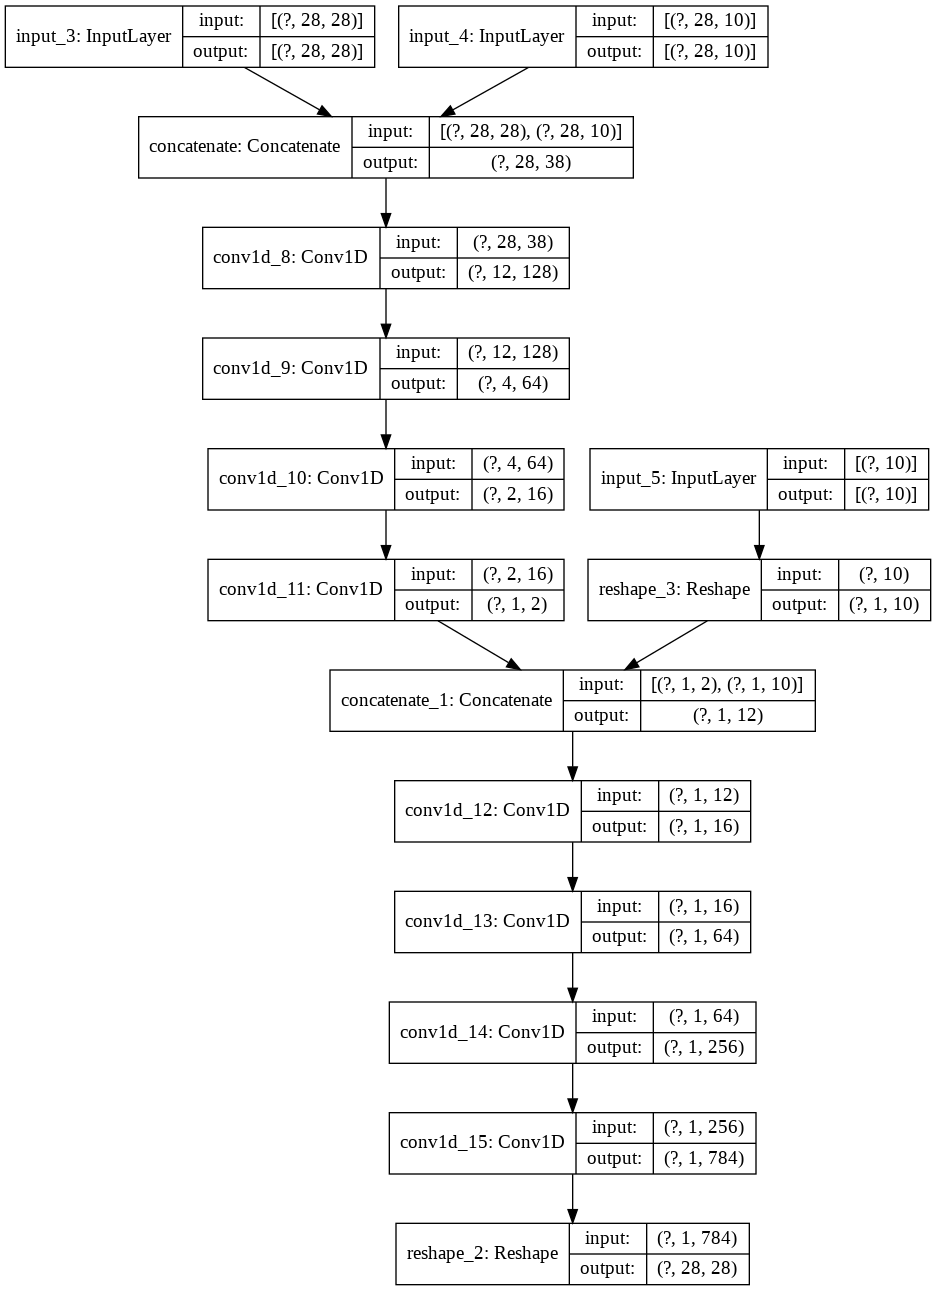

In [ ]:
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

In [ ]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [ ]:
epochs = 20
batch_size = 100
# ae = tf.keras.Model(inputs=[img, cod], outputs=y_pred)
ae.fit([train_images, train_label_onehot, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0570 - mae: 0.1315
Epoch 2/20
600/600 [==============================] - 33s 54ms/step - loss: 0.0435 - mae: 0.1047
Epoch 3/20
600/600 [==============================] - 33s 54ms/step - loss: 0.0388 - mae: 0.0938
Epoch 4/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0367 - mae: 0.0887
Epoch 5/20
600/600 [==============================] - 33s 54ms/step - loss: 0.0357 - mae: 0.0864
Epoch 6/20
600/600 [==============================] - 33s 54ms/step - loss: 0.0350 - mae: 0.0848
Epoch 7/20
600/600 [==============================] - 33s 54ms/step - loss: 0.0345 - mae: 0.0837
Epoch 8/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0341 - mae: 0.0827
Epoch 9/20
600/600 [==============================] - 33s 54ms/step - loss: 0.0338 - mae: 0.0821
Epoch 10/20
600/600 [==============================] - 33s 54ms/step - loss: 0.0336 - mae: 0.0816
Epoch 11/20
600/600 [========

In [ ]:
train_images.shape, train_label_onehots.shape, train_label_onehot.shape

(TensorShape([60000, 28, 28]), (60000, 10), (60000, 28, 10))

# Conditional AutoEncoder를 통과한 결과 그래프로 출력하기

In [ ]:
results = ae([train_images, train_label_onehot, train_label_onehots])

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

# Encoder값을 추출하는 코드 작성하기 

학습된 Encoder의 값을 가져와서 모델화 작업 시행 

이후 Z값을 삽입하여 Z값의 그래프를 그려볼 것임. 

In [ ]:
# Encoder 모델 불러오기.
img = tf.keras.Input(shape=(28,28)) 
con = tf.keras.Input(shape=(28,10))
x = tf.keras.layers.concatenate([img,con], axis=2)

x_enc = enc_dense_1(x)
x_enc = enc_dense_2(x_enc)
x_enc = enc_dense_3(x_enc)
x_enc = enc_dense_4(x_enc)

cond_decoder = models.Model(inputs=[img, con], outputs=x_enc)
z = cond_decoder.predict([train_images,train_label_onehot])
z.shape, train_label_onehot.shape, train_labels.shape

((60000, 1, 2), (60000, 28, 10), (60000,))

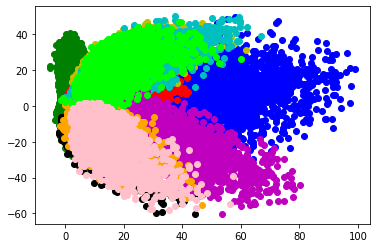

In [ ]:
import matplotlib.pyplot as plt

z_0 = z[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

plt.scatter(z_0[:,:,0], z_0[:,:,1], c='b')
plt.scatter(z_1[:,:,0], z_1[:,:,1], c='g')
plt.scatter(z_2[:,:,0], z_2[:,:,1], c='r')
plt.scatter(z_3[:,:,0], z_3[:,:,1], c='y')
plt.scatter(z_4[:,:,0], z_4[:,:,1], c='k')
plt.scatter(z_5[:,:,0], z_5[:,:,1], c='c')
plt.scatter(z_6[:,:,0], z_6[:,:,1], c='m')
plt.scatter(z_7[:,:,0], z_7[:,:,1], c='orange')
plt.scatter(z_8[:,:,0], z_8[:,:,1], c='lime')
plt.scatter(z_9[:,:,0], z_9[:,:,1], c = 'pink')
plt.show()

# Condition에 따른 Z값 시각화하기

In [ ]:
import ipywidgets as widgets

c = widgets.IntSlider(min=0, max=9)

def z_test(c):
  new_z = z[train_labels == c]
  plt.title('Label {} under encoder'.format(c), fontdict={'fontsize':20})
  plt.scatter(new_z[:,:,0],new_z[:,:,1],c='lime')
  plt.show()  

out = widgets.interactive_output(z_test, {'c':c})

display(c,out)

IntSlider(value=0, max=9)

Output()

조건에 따른 Z값의 분포가 차이가 존재하며 어느정도 뭉쳐있는 모습을 보여준다.

2차원에 조건에 따른 색을 다르게 놓았을 때에 비하여 Label별로 보면 훨씬 잘 구분되는 모습을 보여줌

# 디코더에 Sampling한 값 삽입 결과 확인하기

In [ ]:
# 디코더 모델 정의하기.

## input layer (special purposes for conditional generative model)
z_sample = tf.keras.Input(shape=(2,))
z_sample2 = tf.keras.layers.Reshape((1,2))(z_sample)

decon2 = tf.keras.Input(shape=(10,))
decon22 = tf.keras.layers.Reshape((1,10))(decon2)

z_cond = tf.keras.layers.concatenate([z_sample2, decon22], axis=2)

x_dec = dec_dense_1(z_cond)
x_dec = dec_dense_2(x_dec)
x_dec = dec_dense_3(x_dec)
x_dec = dec_dense_4(x_dec)
y_dec_pred = dec_reshape(x_dec)

cond_decoder = models.Model([z_sample, decon2], y_dec_pred)

In [ ]:
cond_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 2)         0           input_8[0][0]                    
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 1, 10)        0           input_9[0][0]                    
____________________________________________________________________________________________

In [ ]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-20.0, max=20.0)
v=widgets.FloatSlider(min=-20.0, max=20.0)
c = widgets.IntSlider(min=0, max=9)

ui = widgets.HBox([u,v,c])

def z_test(u, v, c):
  z_test = np.array([[u,v]])
  c_test = np.array([list(np.identity(n=10,dtype='float32')[c])])
  print(z_test)

  img_gen = cond_decoder([z_test, c_test])
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v, 'c':c})

display(ui, out)

Output()

# Z의 차원 증대시키기 



In [ ]:
n_dim = 4
# 잠재 차원의 경우 2개로 변경하였다.
img = tf.keras.Input(shape=(28,28)) 
con = tf.keras.Input(shape=(28,10))

enc_dense_1 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='elu',strides=2)
enc_dense_2 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='elu',strides=2)
enc_dense_3 = tf.keras.layers.Conv1D(16,kernel_size=3,activation='elu')
enc_dense_4 = tf.keras.layers.Conv1D(n_dim,kernel_size=2)

x = tf.keras.layers.concatenate([img,con], axis=2)
x = enc_dense_1(x)
x = enc_dense_2(x)
x = enc_dense_3(x)
z = enc_dense_4(x)

dec_dense_1 = tf.keras.layers.Conv1D(16,kernel_size=1,activation='elu')
dec_dense_2 = tf.keras.layers.Conv1D(64,kernel_size=1,activation='elu')
dec_dense_3 = tf.keras.layers.Conv1D(256,kernel_size=1,activation='elu')
dec_dense_4 = tf.keras.layers.Conv1D(784,kernel_size=1,activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))

con2 = tf.keras.Input(shape=(10,))
con22 = tf.keras.layers.Reshape((1,10))(con2)
x = tf.keras.layers.concatenate([z, con22], axis=2)
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

ae = tf.keras.Model(inputs=[img, con, con2], outputs=y_pred)

ae.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_76 (InputLayer)           [(None, 28, 10)]     0                                            
__________________________________________________________________________________________________
concatenate_43 (Concatenate)    (None, 28, 38)       0           input_75[0][0]                   
                                                                 input_76[0][0]                   
__________________________________________________________________________________________________
conv1d_143 (Conv1D)             (None, 12, 128)      24448       concatenate_43[0][0]      

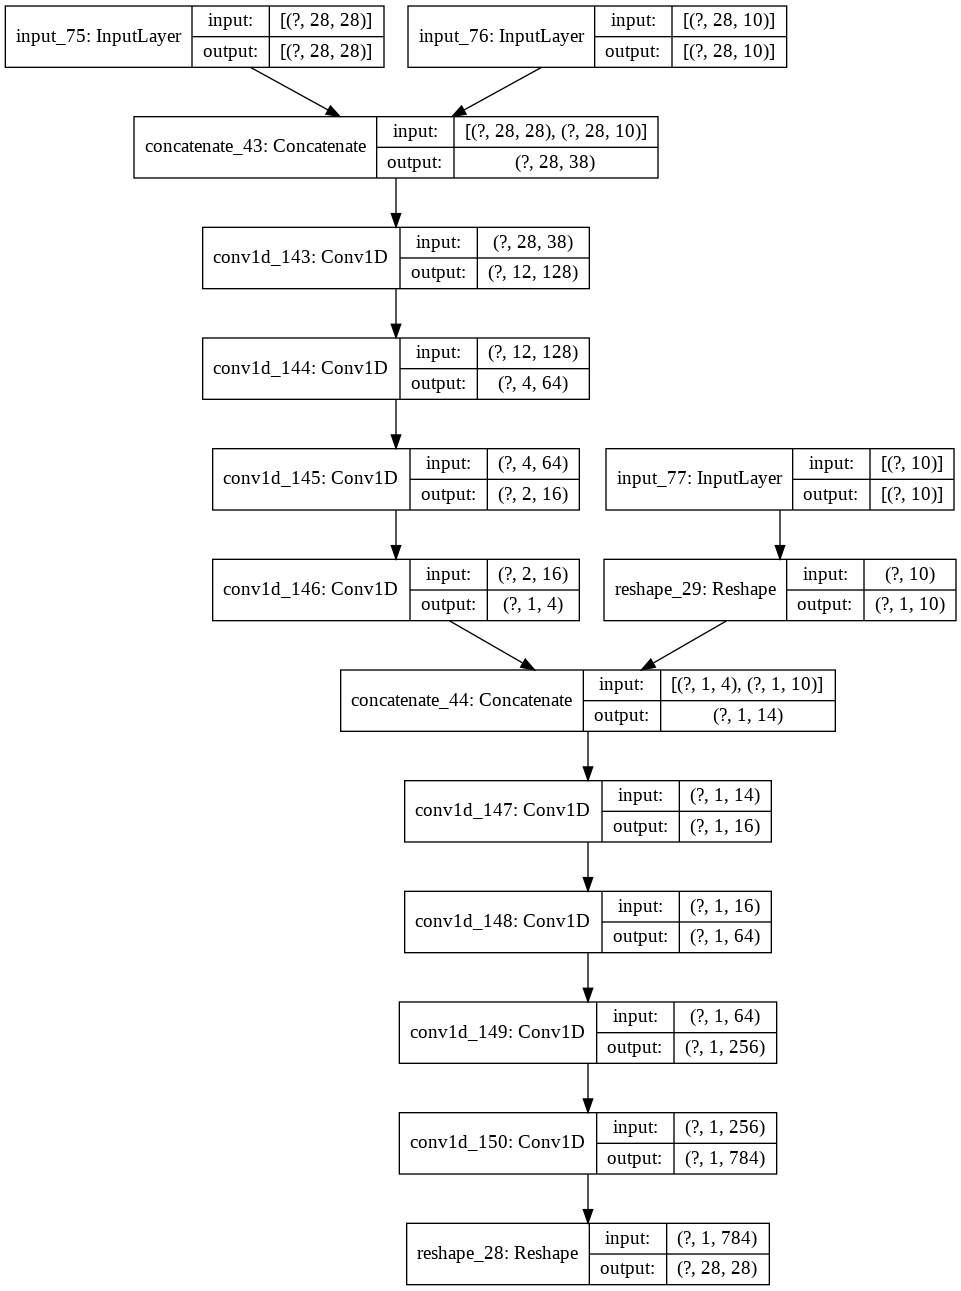

In [ ]:
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

In [ ]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

epochs = 20
batch_size = 100
# ae = tf.keras.Model(inputs=[img, cod], outputs=y_pred)
ae.fit([train_images, train_label_onehot, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0495 - mae: 0.1153
Epoch 2/20
600/600 [==============================] - 35s 59ms/step - loss: 0.0352 - mae: 0.0874
Epoch 3/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0317 - mae: 0.0795
Epoch 4/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0296 - mae: 0.0749
Epoch 5/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0283 - mae: 0.0720
Epoch 6/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0275 - mae: 0.0700
Epoch 7/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0269 - mae: 0.0685
Epoch 8/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0263 - mae: 0.0674
Epoch 9/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0259 - mae: 0.0665
Epoch 10/20
600/600 [==============================] - 33s 55ms/step - loss: 0.0256 - mae: 0.0657
Epoch 11/20
600/600 [========

In [ ]:
results = ae([train_images, train_label_onehot, train_label_onehots])

import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
# Encoder 모델 불러오기.
img = tf.keras.Input(shape=(28,28)) 
con = tf.keras.Input(shape=(28,10))
x = tf.keras.layers.concatenate([img,con], axis=2)

x_enc = enc_dense_1(x)
x_enc = enc_dense_2(x_enc)
x_enc = enc_dense_3(x_enc)
x_enc = enc_dense_4(x_enc)

cond_decoder = models.Model(inputs=[img, con], outputs=x_enc)
z = cond_decoder.predict([train_images,train_label_onehot])
z.shape, train_label_onehot.shape, train_labels.shape

((60000, 1, 4), (60000, 28, 10), (60000,))

# Z값의 분포 그래프


> Z의 차원이 4개이기 때문에 이를 모두 표현하기 위해 그래프 6개를 그려서 확인할 것이다.


> Condition에 따른 분포를 확인하기 위해 6개의 그래프를 한 화면에 출력 시킨 후 조건에 따라 각각의 축값의 변화를 보고자 한다.





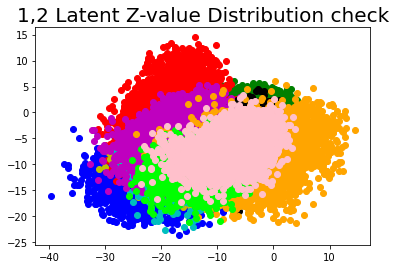

In [ ]:
import matplotlib.pyplot as plt

z_0 = z[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

plt.title('1,2 Latent Z-value Distribution check', fontdict={'fontsize':20})
plt.scatter(z_0[:,:,0], z_0[:,:,1], c='b')
plt.scatter(z_1[:,:,0], z_1[:,:,1], c='g')
plt.scatter(z_2[:,:,0], z_2[:,:,1], c='r')
plt.scatter(z_3[:,:,0], z_3[:,:,1], c='y')
plt.scatter(z_4[:,:,0], z_4[:,:,1], c='k')
plt.scatter(z_5[:,:,0], z_5[:,:,1], c='c')
plt.scatter(z_6[:,:,0], z_6[:,:,1], c='m')
plt.scatter(z_7[:,:,0], z_7[:,:,1], c='orange')
plt.scatter(z_8[:,:,0], z_8[:,:,1], c='lime')
plt.scatter(z_9[:,:,0], z_9[:,:,1], c = 'pink')
plt.show()

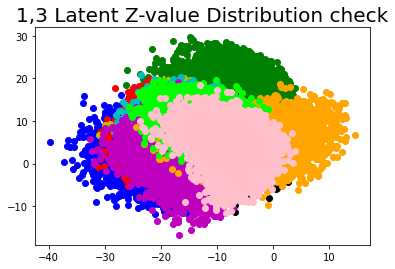

In [ ]:
plt.title('1,3 Latent Z-value Distribution check', fontdict={'fontsize':20})
plt.scatter(z_0[:,:,0], z_0[:,:,2], c='b')
plt.scatter(z_1[:,:,0], z_1[:,:,2], c='g')
plt.scatter(z_2[:,:,0], z_2[:,:,2], c='r')
plt.scatter(z_3[:,:,0], z_3[:,:,2], c='y')
plt.scatter(z_4[:,:,0], z_4[:,:,2], c='k')
plt.scatter(z_5[:,:,0], z_5[:,:,2], c='c')
plt.scatter(z_6[:,:,0], z_6[:,:,2], c='m')
plt.scatter(z_7[:,:,0], z_7[:,:,2], c='orange')
plt.scatter(z_8[:,:,0], z_8[:,:,2], c='lime')
plt.scatter(z_9[:,:,0], z_9[:,:,2], c = 'pink')
plt.show()

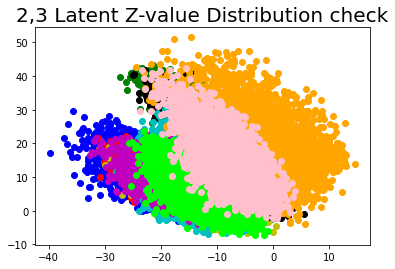

In [ ]:
plt.title('2,3 Latent Z-value Distribution check', fontdict={'fontsize':20})
plt.scatter(z_0[:,:,0], z_0[:,:,3], c='b')
plt.scatter(z_1[:,:,0], z_1[:,:,3], c='g')
plt.scatter(z_2[:,:,0], z_2[:,:,3], c='r')
plt.scatter(z_3[:,:,0], z_3[:,:,3], c='y')
plt.scatter(z_4[:,:,0], z_4[:,:,3], c='k')
plt.scatter(z_5[:,:,0], z_5[:,:,3], c='c')
plt.scatter(z_6[:,:,0], z_6[:,:,3], c='m')
plt.scatter(z_7[:,:,0], z_7[:,:,3], c='orange')
plt.scatter(z_8[:,:,0], z_8[:,:,3], c='lime')
plt.scatter(z_9[:,:,0], z_9[:,:,3], c = 'pink')
plt.show()

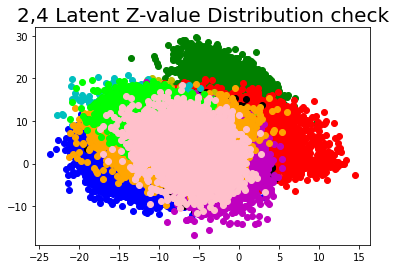

In [ ]:
plt.title('2,4 Latent Z-value Distribution check', fontdict={'fontsize':20})
plt.scatter(z_0[:,:,1], z_0[:,:,2], c='b')
plt.scatter(z_1[:,:,1], z_1[:,:,2], c='g')
plt.scatter(z_2[:,:,1], z_2[:,:,2], c='r')
plt.scatter(z_3[:,:,1], z_3[:,:,2], c='y')
plt.scatter(z_4[:,:,1], z_4[:,:,2], c='k')
plt.scatter(z_5[:,:,1], z_5[:,:,2], c='c')
plt.scatter(z_6[:,:,1], z_6[:,:,2], c='m')
plt.scatter(z_7[:,:,1], z_7[:,:,2], c='orange')
plt.scatter(z_8[:,:,1], z_8[:,:,2], c='lime')
plt.scatter(z_9[:,:,1], z_9[:,:,2], c = 'pink')
plt.show()

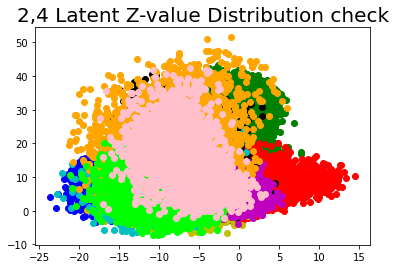

In [ ]:
plt.title('2,4 Latent Z-value Distribution check', fontdict={'fontsize':20})
plt.scatter(z_0[:,:,1], z_0[:,:,3], c='b')
plt.scatter(z_1[:,:,1], z_1[:,:,3], c='g')
plt.scatter(z_2[:,:,1], z_2[:,:,3], c='r')
plt.scatter(z_3[:,:,1], z_3[:,:,3], c='y')
plt.scatter(z_4[:,:,1], z_4[:,:,3], c='k')
plt.scatter(z_5[:,:,1], z_5[:,:,3], c='c')
plt.scatter(z_6[:,:,1], z_6[:,:,3], c='m')
plt.scatter(z_7[:,:,1], z_7[:,:,3], c='orange')
plt.scatter(z_8[:,:,1], z_8[:,:,3], c='lime')
plt.scatter(z_9[:,:,1], z_9[:,:,3], c = 'pink')
plt.show()

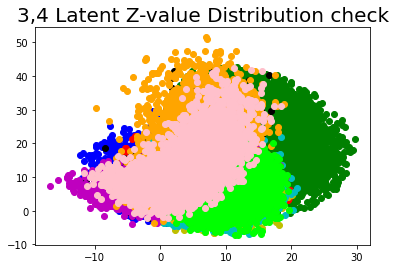

In [ ]:
plt.title('3,4 Latent Z-value Distribution check', fontdict={'fontsize':20})
plt.scatter(z_0[:,:,2], z_0[:,:,3], c='b')
plt.scatter(z_1[:,:,2], z_1[:,:,3], c='g')
plt.scatter(z_2[:,:,2], z_2[:,:,3], c='r')
plt.scatter(z_3[:,:,2], z_3[:,:,3], c='y')
plt.scatter(z_4[:,:,2], z_4[:,:,3], c='k')
plt.scatter(z_5[:,:,2], z_5[:,:,3], c='c')
plt.scatter(z_6[:,:,2], z_6[:,:,3], c='m')
plt.scatter(z_7[:,:,2], z_7[:,:,3], c='orange')
plt.scatter(z_8[:,:,2], z_8[:,:,3], c='lime')
plt.scatter(z_9[:,:,2], z_9[:,:,3], c = 'pink')
plt.show()

In [ ]:
import ipywidgets as widgets

c = widgets.IntSlider(min=0, max=9)

def z_test(c):
  new_z = z[train_labels == c]
  plt.figure(figsize = (32,20))
  plt.subplot(231)
  plt.title('Label {} under encoder'.format(c), fontdict={'fontsize':20})
  plt.scatter(new_z[:,:,0],new_z[:,:,1],c='r')

  plt.subplot(232)
  plt.title('Label {} under encoder'.format(c), fontdict={'fontsize':20})
  plt.scatter(new_z[:,:,0],new_z[:,:,2],c='g')

  plt.subplot(233)
  plt.title('Label {} under encoder'.format(c), fontdict={'fontsize':20})
  plt.scatter(new_z[:,:,0],new_z[:,:,3],c='b')

  plt.subplot(234)
  plt.title('Label {} under encoder'.format(c), fontdict={'fontsize':20})
  plt.scatter(new_z[:,:,1],new_z[:,:,2],c='lime')

  plt.subplot(235)
  plt.title('Label {} under encoder'.format(c), fontdict={'fontsize':20})
  plt.scatter(new_z[:,:,1],new_z[:,:,3],c='orange')

  plt.subplot(236)
  plt.title('Label {} under encoder'.format(c), fontdict={'fontsize':20})
  plt.scatter(new_z[:,:,2],new_z[:,:,3],c='pink')
  plt.show()  

out = widgets.interactive_output(z_test, {'c':c})

display(c,out)

IntSlider(value=0, max=9)

Output()

In [ ]:
# 디코더 모델 정의하기.

## input layer (special purposes for conditional generative model)
z_sample = tf.keras.Input(shape=(n_dim,))
z_sample2 = tf.keras.layers.Reshape((1,n_dim))(z_sample)

decon2 = tf.keras.Input(shape=(10,))
decon22 = tf.keras.layers.Reshape((1,10))(decon2)

z_cond = tf.keras.layers.concatenate([z_sample2, decon22], axis=2)

x_dec = dec_dense_1(z_cond)
x_dec = dec_dense_2(x_dec)
x_dec = dec_dense_3(x_dec)
x_dec = dec_dense_4(x_dec)
y_dec_pred = dec_reshape(x_dec)

cond_decoder = models.Model([z_sample, decon2], y_dec_pred)

In [ ]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

s=widgets.FloatSlider(min=-30.0, max=30.0)
t=widgets.FloatSlider(min=-30.0, max=30.0)
u=widgets.FloatSlider(min=-30.0, max=30.0)
v=widgets.FloatSlider(min=-30.0, max=30.0)
c = widgets.IntSlider(min=0, max=9)

ui = widgets.HBox([s,t,u,v,c])

def z_test(s,t,u, v, c):
  z_test = np.array([[s,t,u,v]])
  c_test = np.array([list(np.identity(n=10,dtype='float32')[c])])
  print(z_test)

  img_gen = cond_decoder([z_test, c_test])
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'s':s, 't':t, 'u': u, 'v': v, 'c':c})

display(ui, out)

Output()

# 만들어진 이미지 특징



1.   제대로 구분할 수 있는 Vector의 값을 찾기가 어려움이 있다.
2.   전체적인 그림이 흐릿한 경향이 있다.
3.   다른 입력된 데이터들의 특징이 묻어오는 경향이 있다.



